## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests
import random
import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [2]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, mask_ratio=0.75, indexlist:list=[],):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio, vis_indices=indexlist)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

### Load a pre-trained MAE model

In [3]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('mae_vit_large_patch16 Model loaded.')


# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

# chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
# model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
# print('Model loaded.')

File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
mae_vit_large_patch16 Model loaded.


In [4]:
# Find the pure non-black patch indices
import cv2
import numpy as np

def find_nonblack_index(image, img_size=224, patch_size=16, threshold=1):
    '''
    array: a numpy array (224,224,3)
    threshold: number of black pixels allowed

    return:
    indices : list of index
    '''
    # image = np.array(image)
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = np.array(image)
    else:
        gray_image = image

    grid_size = (img_size // patch_size) 
    patch_indices = []

    for i in range(grid_size):
        for j in range(grid_size):
            patch = gray_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            
            black_pixel_count = np.sum(patch == 0)
            if black_pixel_count < threshold:
                patch_index = i * grid_size + j
                patch_indices.append(patch_index)
            # if np.all(patch != 0): # Very strict, if black pixels exist, then filter them
            #     patch_index = i * grid_size + j
            #     patch_indices.append(patch_index)
    return patch_indices

def find_closingcirle(imgroot, show_plot=True, show_grid=True):
    ''''
    imgroot: path the the image
    show_plot: if True, return the image with the circle on, used for visualization;
                if False, return the squared image resized to 224x224
    '''
    gray = cv2.imread(imgroot, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(imgroot,)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Check how many connected components
    mask = gray != 0
    white_image = np.ones_like(gray) * 255
    result_image = np.where(mask, white_image, gray)
    kernel = np.ones((3, 3), np.uint8)
    result_image = cv2.morphologyEx(result_image, cv2.MORPH_OPEN, kernel) #(erosion followed by dilation)
    result_image = cv2.morphologyEx(result_image, cv2.MORPH_CLOSE, kernel) #(dilation followed by erosion)
    result_image = cv2.GaussianBlur(result_image, (5, 5), 0)
    _, _, _, centroids = cv2.connectedComponentsWithStats(result_image)
    aver_point = np.average(centroids[1:],axis=0)

    if len(centroids) > 1:
        for center in centroids:
            cv2.line(result_image, aver_point.astype(int), center.astype(int), 50, 2)

    # Draw the min enclosing circle
    _, binary = cv2.threshold(result_image, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    center = (int(x), int(y))
    radius = int(radius)

    # calculate the padding
    top_padding = max(0, radius - center[1])
    bottom_padding = max(0, radius - (image.shape[0] - center[1]))
    left_padding = max(0, radius - center[0])
    right_padding = max(0, radius - (image.shape[1] - center[0]))
    padding_image = cv2.copyMakeBorder(
        image,
        top_padding, bottom_padding, left_padding, right_padding,
        cv2.BORDER_CONSTANT, value=[0,0,0]
    )
    padding_image224 = cv2.resize(padding_image, (224,224))    
    nonblack_index = find_nonblack_index(np.array(padding_image224))

    if not show_plot:
        return (padding_image224, nonblack_index)
    
    else:
        import os
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        cropimgroot = imgroot.replace("MaskedImg","CroppedImg")
        cropimage_ = cv2.imread(cropimgroot)
        cropimg = cv2.copyMakeBorder(
            cropimage_,
            top_padding, bottom_padding, left_padding, right_padding,
            cv2.BORDER_CONSTANT, value=[255,255,255]
        )
        new_center = (center[0] + left_padding, center[1]+top_padding)

        cv2.circle(cropimg, new_center, radius, (255, 0, 0), 5)
        plt.title(f'Ori+Bgd:{os.path.basename(imgroot)}')
        plt.imshow(cv2.cvtColor(cropimg, cv2.COLOR_BGR2RGB))
        # plt.axis('off')

        cv2.circle(padding_image, new_center, radius, (255, 255, 255), 5)

        plt.subplot(1,3,2)
        plt.title(f'Ori:{os.path.basename(imgroot)}')
        plt.imshow(cv2.cvtColor(padding_image, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        cv2.circle(padding_image224, (112,112), 112, (0, 255, 0), 1)
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,3)
        plt.title(f'Resized224:{os.path.basename(imgroot)}')
        plt.imshow(cv2.cvtColor(padding_image224, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        if show_grid:
            major_ticks_x = np.arange(0, 224, 16)  # main grid, each 16 units
            plt.xticks(major_ticks_x)
            plt.grid(which='major', linestyle='-', linewidth='0.5', color='white')  
            plt.yticks(major_ticks_x)
            plt.grid(which='major', linestyle='-', linewidth='0.5', color='white') 
            plt.grid("on",)
            image_size = 224
            cell_size = 16
            grid_size = image_size//cell_size
            
            # binary224 = cv2.resize(binary, (224,224))
            # print(len(nonblack_index))
            index=0
            for x in range(grid_size):
                for y in range(grid_size):
                    x_loc = (x+1)*cell_size - cell_size/2
                    y_loc = (y+1)*cell_size - cell_size/2
                    clr = 'red' if index in nonblack_index else 'white' 
                    plt.text(int(y_loc), int(x_loc),s=str(index), fontsize=15, color=clr, ha='center', va='center')
                    index += 1

/home/ziangzhao/Datasets/AppleDataset/MaskedImg/IMG_2303_3.jpg


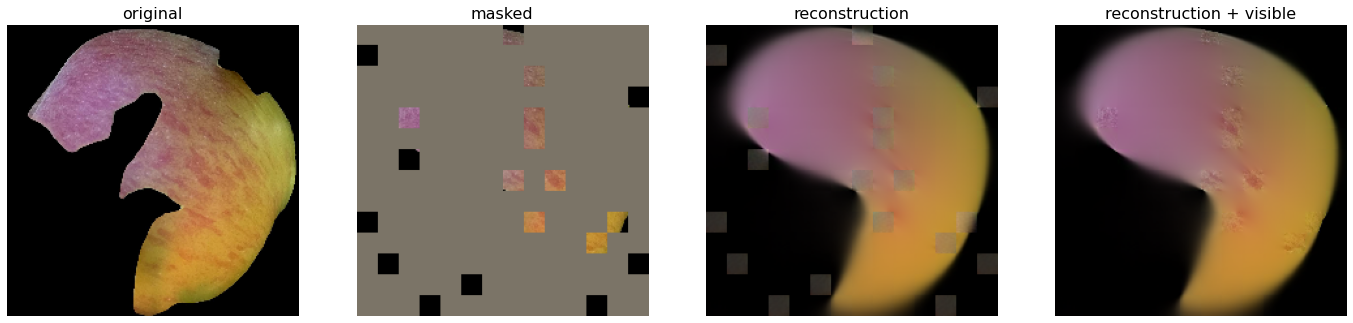

In [9]:
# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/MaskedImg_stdapp/"
# img_list = os.listdir(img_root)
# # idx=random.randint(0,len(img_list))
# img_path = img_root + img_list[6]

img_path = '/home/ziangzhao/Datasets/AppleDataset/MaskedImg/IMG_2303_3.jpg' #IMG_2243_2 #IMG_2251_1 #IMG_2873_5
print(img_path)
padding_image224, nonblack_index = find_closingcirle(img_path, show_plot=False, show_grid=False)

padding_image224 = np.array(padding_image224) / 255.

assert padding_image224.shape == (224, 224, 3)

# normalize by ImageNet mean and std
padding_image224 = padding_image224 - imagenet_mean
padding_image224 = padding_image224 / imagenet_std
run_one_image(padding_image224, model_mae, mask_ratio=0.9, indexlist=nonblack_index)

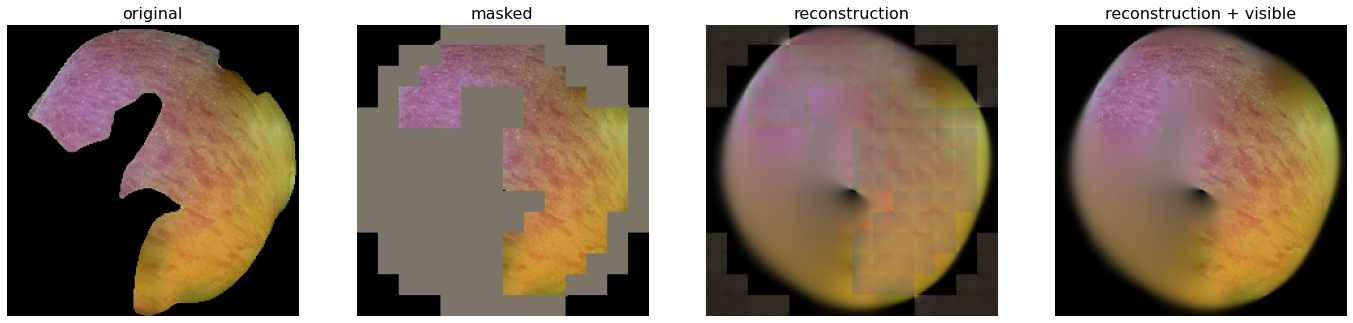

In [10]:
run_one_image(padding_image224, model_mae, mask_ratio=0, indexlist=nonblack_index)

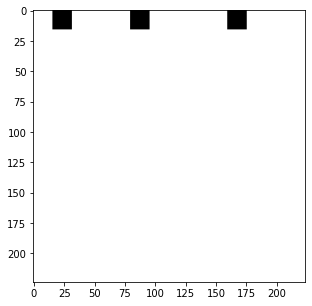

In [6]:
import numpy
from PIL import Image
# num_mask  = [0,1,2,3,14,15,28,42] #+ [10,11,12,13,26,27,41,55] + [140,154,168,169,182,183,184,185] + [153,167,180,181,192,193,194,195]
num_mask = [1,5,10]
L = 196
N = 1
keep = set(num_mask)
remove = set(range(L)) - keep

ids = num_mask + list(remove)
# ids_ = torch.tensor(numpy.array([ids]))
# ids_restore = torch.argsort(ids_, dim=1)
ids_ = torch.arange(L).reshape(1,-1)
mask = torch.ones([N, L])
mask[:, num_mask] = 0
mask = torch.gather(mask, dim=1, index=ids_)

model = model_mae
# mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu().numpy()
# img=Image.fromarray(mask[0])
mk = mask[0]
plt.figure(figsize=(5,5))
plt.imshow(mk)
# ids_restore

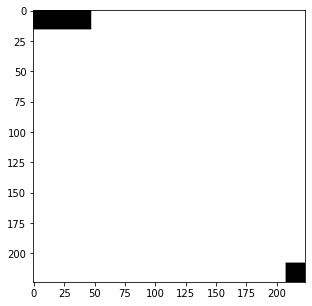

In [7]:
len_keep = [0,1,2,195]
# noise = torch.rand(N, L,)  # noise in [0, 1]
# import ipdb; ipdb.set_trace()
# sort noise for each sample
# ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
# ids_restore = torch.argsort(ids_shuffle, dim=1)
# ids_keep = ids_shuffle[:, :len_keep]

ids_ = torch.arange(L).reshape(1,-1)
# ids_restore = ids_
# ids_keep = ids_[:, :len_keep]


# generate the binary mask: 0 is keep, 1 is remove
mask = torch.ones([N, L])
mask[:, len_keep] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_)

model = model_mae
# mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu().numpy()
# img=Image.fromarray(mask[0])
mk = mask[0]
plt.figure(figsize=(5,5))
plt.imshow(mk)

In [20]:
len_keep = 50
noise = torch.rand(N, L,)  # noise in [0, 1]
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)
ids_keep = ids_shuffle[:, :len_keep]
ids_shuffle, ids_keep

(tensor([[ 70,  26,  96,  71, 100,  65, 149,  33,   6,  62,  60,   1,  61,  72,
           83, 139,  18, 169, 174,  91,  95, 121,  49, 173, 194,  63, 146, 127,
           28, 125, 192, 183, 162,  44, 104,  16,  32,  76, 103,   3, 153,   9,
          188,  59,  89, 132,  22, 124, 157,  54,  34, 152,  15, 171,  35, 142,
           12,  88,  46,  78, 186, 111,  42, 112,  97, 181, 148, 182, 166,  48,
          136,  19, 190,  92, 163, 110,  47, 126, 144,  98,  57, 114, 150,  67,
           30,   7, 155, 180,   5,  23,  99, 117, 167,   4,   2, 140, 102, 118,
           21, 160, 156, 116, 178,  55, 128,  14, 138,  77, 189,  52,   0,  87,
          108,  79, 172,  73, 120, 115, 107,  93,  90, 184, 106,  50,  64,  84,
           11, 113,   8, 135, 193,  36, 165,  37, 154, 187, 195, 158, 119,  24,
          137, 123,  80,  40,  75,  10,  86, 134,  39,  82,  31,  94, 130,  45,
           13, 151,  20,  69,  53, 131, 179,  25, 147,  68, 161,  29, 101,  17,
           43, 143, 105, 170, 176, 191, 

In [19]:
ids_restore

tensor([[ 84,  65,  33,  39, 190, 155, 129,   9,  85,  48,  76, 126,  62,  74,
         110,  32, 112, 146,   0, 141,  49,  55, 142,  29,  70,  94, 103, 109,
         161, 116,  90,  13,   4,   3, 168,  97, 193, 101, 124, 125, 107,  75,
         104, 158, 115,  69,  41,  57,  47,  64, 181,  30, 102,  20,  53,  31,
          10, 108, 172,  27, 194, 138, 105,  61,  11,  46,  52,  98, 119, 162,
          68,  54,  93,  18,  42,  15, 173,  22, 195, 166, 151,  40,  77, 143,
           6, 164, 153, 192, 183,  45,   1, 159, 176,  24, 152,  36,   2, 106,
         147, 113, 144, 145,  21, 100, 189, 136, 127, 120, 114, 149,  25, 174,
          50,  83, 169,  71, 179, 132,  38,  56, 131,  72, 137,  14, 175,  16,
         121, 178,  23,   8, 134,  86, 157,   5, 165, 160,  51, 156,  28,  89,
         171, 118, 122, 186,  67,  35, 191,  26,  95,  92, 148,  80,  73,   7,
         154,  43,  87,  96,  82, 140, 185, 188, 130, 167,  37, 170,  81, 139,
          91,  60, 128, 117, 177,  63, 150, 163,  79

### Run MAE on the image

MAE with pixel reconstruction:


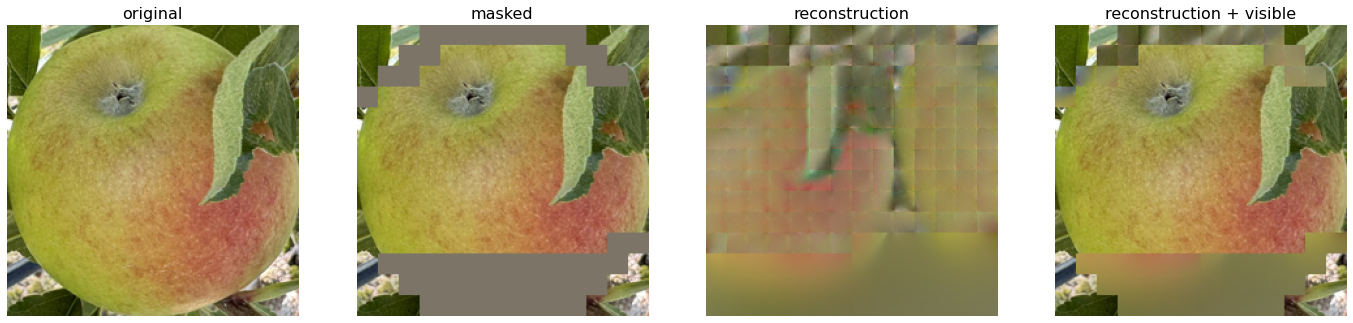

MAE with extra GAN loss:


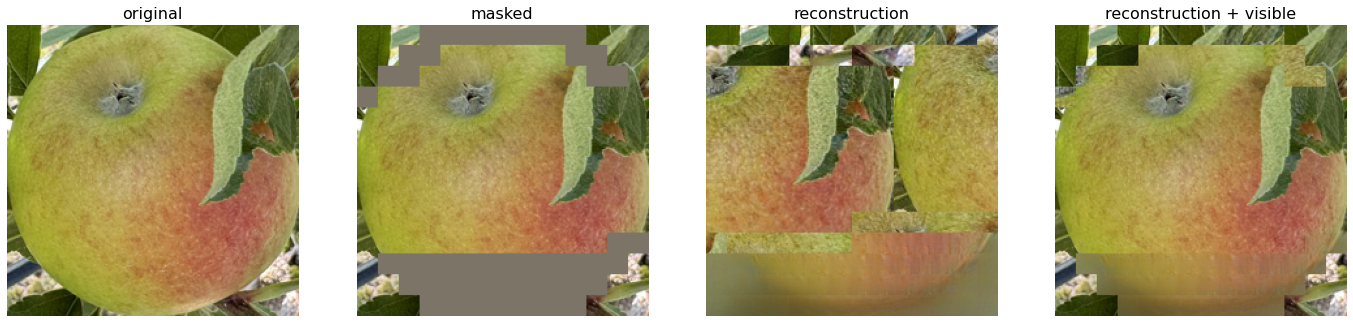

In [ ]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# # img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/CroppedImg/IMG_2216_2.jpg"
img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/CroppedImg_stdapp/"
img_list = os.listdir(img_root)
idx=random.randint(0,len(img_list))
img_path = img_root + img_list[idx]
img = Image.open(img_path)
# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/IMG_2218.jpg"
# img = Image.open(img_root)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

# plt.rcParams['figure.figsize'] = [5, 5]
# show_image(torch.tensor(img))

# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

In [ ]:
img_path

'/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/MaskedImg_stdapp/IMG_3510_1.jpg'